# Linear Regression in Python

## Does parenting style experienced in teen years affect arrests?
Parenting styles:
* Authoritative (A) - *rule enforcement and a positive relationship*
* Authoritarian (N) - *seeking obedience through punishment*
* Permissive (P) - *lack of enforcement of rules*
* Uninvolved (U) - *giving the child little guidance or attention*

### Hypothesis
* H1: There is a significant correlation between the parenting style experienced in teen years and lifetime arrests.
* H0: There is no significant correlation between the parenting style experienced in teen years and lifetime arrests.

### The data:
* Population: U.S. youth age 13 or younger by the start of 1997 that live with at least one parental figure
* Sample: data from National Longitudinal Study - Youth 1997 (NLSY97) of the Bureau of Labor Statistics (BLS)
* Data is oversampled for blacks
   * Oversampling will make regression results for blacks--a smaller group--more accurate than without oversampling
   * However, descriptive statistics won't accurately reflect the population without weights to correct for oversampling
-----

## Importing the data and codebook

* I have three files: the data, the survey questions, and the survey answer key.
* Below, I'll rename the variables to make them more user-friendly and create a dictionary to reference each variable's question and answers.

In [1]:
# Import data manipulation tools
import pandas as pd
import numpy as np

# Import data vizualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import statistical modeling tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Import data for regression
path = 'C:/Users/Hillary/Data_Science/Curfew_Project/curfew/curfew.csv'
df_curfew = pd.read_csv(path)

df_curfew.info()
df_curfew.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8984 entries, 0 to 8983
Data columns (total 20 columns):
E8033100    8984 non-null int64
E8043100    8984 non-null int64
E8043500    8984 non-null int64
R0000100    8984 non-null int64
R0070700    8984 non-null int64
R0343700    8984 non-null int64
R0344200    8984 non-null int64
R0344900    8984 non-null int64
R0360300    8984 non-null int64
R0360400    8984 non-null int64
R0360500    8984 non-null int64
R0365900    8984 non-null int64
R0366000    8984 non-null int64
R0536300    8984 non-null int64
R0536401    8984 non-null int64
R0536402    8984 non-null int64
R0648900    8984 non-null int64
R1204500    8984 non-null int64
R1235800    8984 non-null int64
R1482600    8984 non-null int64
dtypes: int64(20)
memory usage: 1.4 MB


E8033100  E8043100  E8043500  R0000100  R0070700  R0343700  R0344200  \
0         0         0         0         1         1        -4        -4   
1         0         0         0         2         1        -4        -4   
2         0         0         0         3         1         1         2   
3         0         0         0         4         4        -4        -4   
4         0         0         0         5         2        -4        -4   

   R0344900  R0360300  R0360400  R0360500  R0365900  R0366000  R0536300  \
0        -4         0         0         0         0        -4         2   
1        -4         0         0         0         0        -4         1   
2         1         1         0         0         0        -4         2   
3        -4         1         1         0         0        -4         2   
4        -4         1         1         0         0        -4         1   

   R0536401  R0536402  R0648900  R1204500  R1235800  R1482600  
0         9      1981         0        -3         1         4  
1         7      1982        -4        -4         1         2  
2         9      1983         0     63000         1         2  
3         2      1981         0     11700         1         2  
4        10      1982         0        -3         1         2

In [3]:
# Import survey questions
df_questions = pd.read_csv('curfew-questions.csv')

df_questions.head()

ID               VAR                                      Q
0  E8033100     ARREST_TOTNUM                TOTAL NUMBER OF ARRESTS
1  E8043100     INCARC_TOTNUM         TOTAL NUMBER OF INCARCERATIONS
2  E8043500  INCARC_TOTMONTHS              TOTAL MONTHS INCARCERATED
3  R0000100             PUBID  PUBID, YOUTH CASE IDENTIFICATION CODE
4  R0070700         YPRS-1000      PERCENT OF PEERS BELONG TO A GANG

In [4]:
# Import survey answer key
df_answers = pd.read_csv('curfew_answer_key.csv', names='A')

df_answers.head()

A
0  label define vlE8033100 0 "0"  1 "1 TO 4"  5 "...
1                   label values E8033100 vlE8033100
2  label define vlE8043100 0 "0: No incarceration...
3                   label values E8043100 vlE8043100
4  label define vlR0000100 0 "0"  1 "1 TO 999"  1...

In [5]:
# Create function to delete unnecessary info in survey answer key data
def clean_answers(row):
    if 'label define' in row:
        return row[15:]  
    else:
        return None

# Run above function and drop null rows
df_answers = df_answers['A'].apply(clean_answers).dropna()

# Split data into ID (question ID) and ANS (answer key)
df_answers = pd.DataFrame(df_answers.str.split(' ',1).tolist(), columns=['ID', 'ANS']) 

df_answers.head()

ID                                                ANS
0  E8033100  0 "0"  1 "1 TO 4"  5 "5 TO 9"  10 "10 TO 14"  ...
1  E8043100  0 "0: No incarcerations"  1 "1 TO 2: incarcera...
2  R0000100  0 "0"  1 "1 TO 999"  1000 "1000 TO 1999"  2000...
3  R0070700  1 "1.  Almost none (less than 10%)"  2 "2.  Ab...
4  R0343700  1 "PARENT OR PARENTS SET LIMITS"  2 "PARENTS L...

In [6]:
# Create Q&A dataframe by merging survey questions and answer key
df_qa = df_answers.merge(df_questions, on='ID')

df_qa = df_qa.drop(columns=['VAR'])

df_qa

ID                                                ANS  \
0   E8033100  0 "0"  1 "1 TO 4"  5 "5 TO 9"  10 "10 TO 14"  ...   
1   E8043100  0 "0: No incarcerations"  1 "1 TO 2: incarcera...   
2   R0000100  0 "0"  1 "1 TO 999"  1000 "1000 TO 1999"  2000...   
3   R0070700  1 "1.  Almost none (less than 10%)"  2 "2.  Ab...   
4   R0343700  1 "PARENT OR PARENTS SET LIMITS"  2 "PARENTS L...   
5   R0344200  0 "0"  1 "1"  2 "2"  3 "3"  4 "4"  5 "5"  6 "6...   
6   R0344900  1 "DISCUSS IT CALMLY WITH YOU"  2 "IGNORE IT, ...   
7   R0360300                                    0 "No"  1 "Yes"   
8   R0360400                                    0 "No"  1 "Yes"   
9   R0360500                                    0 "No"  1 "Yes"   
10  R0365900                                    0 "No"  1 "Yes"   
11  R0366000  0 "0"  1 "1"  2 "2"  3 "3"  4 "4"  5 "5"  6 "6...   
12  R0536300           0 "No Information"  1 "Male"  2 "Female"   
13  R0536401  1 "1: January"  2 "2: February"  3 "3: March" ...   
14  R0648900                                    0 "No"  1 "Yes"   
15  R1204500  -999999 "-999999 TO -3000: < -2999"  -2999 "-2...   
16  R1235800                0 "Oversample"  1 "Cross-sectional"   
17  R1482600  1 "Black"  2 "Hispanic"  3 "Mixed Race (Non-Hi...   

                                                    Q  
0                             TOTAL NUMBER OF ARRESTS  
1                      TOTAL NUMBER OF INCARCERATIONS  
2               PUBID, YOUTH CASE IDENTIFICATION CODE  
3                   PERCENT OF PEERS BELONG TO A GANG  
4                          WHO SETS RS CURFEW LIMITS?  
5          R BROKE LIMITS FOR CURFEW IN LAST 30 DAYS?  
6         WHAT WOULD PARENT(S) DO IF R BREAKS CURFEW?  
7               ANY GANG IN RS NEIGHBORHOOD OR SCHOOL  
8        ANY RS BROTHERS, SISTERS, FRIENDS IN A GANG?  
9                            R EVER BELONGED TO GANG?  
10  R EVER ARRESTED FOR ILLEGAL OR DELINQUENT OFFE...  
11                           TOTAL # TIMES R ARRESTED  
12                        KEY!SEX, RS GENDER (SYMBOL)  
13        KEY!BDATE, RS BIRTHDATE MONTH/YEAR (SYMBOL)  
14                    R EVER LIVE THROUGH HARD TIMES?  
15                       GROSS HH INCOME IN PAST YEAR  
16         SAMPLE TYPE. CROSS-SECTIONAL OR OVERSAMPLE  
17  KEY!RACE_ETHNICITY, COMBINED RACE AND ETHNICIT...

In [7]:
# Create variable names
var_list = ['ARREST_TOT', 'INCAR_TOT', 'PUBID', 'PERC_PEERS_GANG', 'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG', 'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX', 'BIRTH_MO', 'HARD_TIMES97', 'HH_INCOME97', 'CV_SAMPLE_TYPE', 'RACE_ETH']

df_qa['VAR'] = var_list

df_qa.head()

ID                                                ANS  \
0  E8033100  0 "0"  1 "1 TO 4"  5 "5 TO 9"  10 "10 TO 14"  ...   
1  E8043100  0 "0: No incarcerations"  1 "1 TO 2: incarcera...   
2  R0000100  0 "0"  1 "1 TO 999"  1000 "1000 TO 1999"  2000...   
3  R0070700  1 "1.  Almost none (less than 10%)"  2 "2.  Ab...   
4  R0343700  1 "PARENT OR PARENTS SET LIMITS"  2 "PARENTS L...   

                                       Q              VAR  
0                TOTAL NUMBER OF ARRESTS       ARREST_TOT  
1         TOTAL NUMBER OF INCARCERATIONS        INCAR_TOT  
2  PUBID, YOUTH CASE IDENTIFICATION CODE            PUBID  
3      PERCENT OF PEERS BELONG TO A GANG  PERC_PEERS_GANG  
4             WHO SETS RS CURFEW LIMITS?    WHO_SETS_CURF

In [8]:
# Make dictionary of ID and VAR to rename variables in data
df_idvar = df_qa[['ID', 'VAR']]

dict_rename_vars = df_idvar.set_index('ID')['VAR'].T.to_dict()

dict_rename_vars

{'E8033100': 'ARREST_TOT',
 'E8043100': 'INCAR_TOT',
 'R0000100': 'PUBID',
 'R0070700': 'PERC_PEERS_GANG',
 'R0343700': 'WHO_SETS_CURF',
 'R0344200': 'BR_CURF_L30',
 'R0344900': 'CURF_ENFORCM',
 'R0360300': 'NEIGH_SCH_GANG',
 'R0360400': 'SIB_FR_GANG',
 'R0360500': 'EV_GANG',
 'R0365900': 'R_ARRESTED_EV',
 'R0366000': 'ARREST_TOT97',
 'R0536300': 'SEX',
 'R0536401': 'BIRTH_MO',
 'R0648900': 'HARD_TIMES97',
 'R1204500': 'HH_INCOME97',
 'R1235800': 'CV_SAMPLE_TYPE',
 'R1482600': 'RACE_ETH'}

In [9]:
# Check for missed variables
rename_vars_set = set(list(dict_rename_vars.keys()))
column_vars_set = set(list(df_curfew.columns))

missed_vars = list(column_vars_set - rename_vars_set)

missed_vars

['R0536402', 'E8043500']

In [10]:
# Rename variables with dictionary
df_curfew = df_curfew.rename(columns=dict_rename_vars)

# Add variable names to missed variables from last cell
df_curfew = df_curfew.rename(columns={'R0536402' : 'BIRTH_YR', 'E8043500': 'INCAR_TOT_MO'})

list(df_curfew.columns)

['ARREST_TOT',
 'INCAR_TOT',
 'INCAR_TOT_MO',
 'PUBID',
 'PERC_PEERS_GANG',
 'WHO_SETS_CURF',
 'BR_CURF_L30',
 'CURF_ENFORCM',
 'NEIGH_SCH_GANG',
 'SIB_FR_GANG',
 'EV_GANG',
 'R_ARRESTED_EV',
 'ARREST_TOT97',
 'SEX',
 'BIRTH_MO',
 'BIRTH_YR',
 'HARD_TIMES97',
 'HH_INCOME97',
 'CV_SAMPLE_TYPE',
 'RACE_ETH']

In [11]:
# Make dictionary of data Q&A for codebook reference
df_qa = df_qa[['VAR', 'Q','ANS']]
dict_aq = df_qa.set_index('VAR').T.to_dict()

# Add missing variable to dictionary
dict_aq['INCAR_TOT_MO'] = '-3 "invalid skip"  -4 "valid skip"  -5 "noninterview"' 

# Dictionary test: what is the survey question and answers for variable BR_CURF_L30?
dict_aq['WHO_SETS_CURF']

{'Q': 'WHO SETS RS CURFEW LIMITS?',
 'ANS': '1 "PARENT OR PARENTS SET LIMITS"  2 "PARENTS LET ME DECIDE"  3 "MY PARENTS AND I DECIDE JOINTLY"'}

## Clean and prep data for regression

* Drop unneeded variables
* Reduce data to include only relevant survey participants
* Recode/drop NaN values for each variable
* Create dummy variables where appropriate (sex, race, sex/race interaction)

In [12]:
# Drop unneeded variables
df_curfew.drop(['PUBID', 'CV_SAMPLE_TYPE', 'BIRTH_MO', 'BIRTH_YR', 'HARD_TIMES97'], inplace=True, axis=1)

In [13]:
# Check various NaN values for each variable, coded as being < 0
df_curfew[df_curfew < 0].apply(pd.Series.value_counts)

ARREST_TOT  INCAR_TOT  INCAR_TOT_MO  PERC_PEERS_GANG  WHO_SETS_CURF  \
-48100.0         NaN        NaN           NaN              NaN            NaN   
-8050.0          NaN        NaN           NaN              NaN            NaN   
-7500.0          NaN        NaN           NaN              NaN            NaN   
-4.0             NaN        NaN           NaN              6.0         5470.0   
-3.0             NaN       19.0          20.0              1.0            1.0   
-2.0             NaN        NaN           NaN            163.0            2.0   
-1.0             NaN        NaN           NaN              2.0            5.0   

          BR_CURF_L30  CURF_ENFORCM  NEIGH_SCH_GANG  SIB_FR_GANG  EV_GANG  \
-48100.0          NaN           NaN             NaN          NaN      NaN   
-8050.0           NaN           NaN             NaN          NaN      NaN   
-7500.0           NaN           NaN             NaN          NaN      NaN   
-4.0           5580.0        5580.0             NaN          NaN      NaN   
-3.0              1.0           1.0             2.0          2.0      2.0   
-2.0              3.0           8.0            61.0         34.0      4.0   
-1.0              3.0           3.0            14.0         15.0     16.0   

          R_ARRESTED_EV  ARREST_TOT97  SEX  HH_INCOME97  RACE_ETH  
-48100.0            NaN           NaN  NaN          1.0       NaN  
-8050.0             NaN           NaN  NaN          1.0       NaN  
-7500.0             NaN           NaN  NaN          1.0       NaN  
-4.0                NaN        8255.0  NaN        938.0       NaN  
-3.0                2.0           NaN  NaN       1458.0       NaN  
-2.0                5.0           1.0  NaN          NaN       NaN  
-1.0               20.0           1.0  NaN          NaN       NaN

### Understanding our parenting style variables (proxies!)


Our first two variables we'll be dealing with are WHO_SETS_CURF and CURF_ENFORC.

**I'm using these variables as proxies for four parenting styles: [Authoritative (A), Authoritarian (N), Permissive (P), Uninvolved (U)](https://www.verywellfamily.com/types-of-parenting-styles-1095045)**

* WHO_SETS_CURF ("Who sets RS curfew limits?") gives three options to respondents:
    * 1 - Parent or parents set limits
    * 2 - Parents let me decide
    * 3- My parents and I decide jointly

**I'm using the child setting their own curfew (2) as having parents with an *Uninvolved* parenting style, which is characterized as giving the child little guidance or attention.**

For the subset of children who have curfews (set by the parent or jointly), they are asked how their parent enforces their curfew if they break it. The answers will be categorized into the three remaining parenting styles.

* CURF_ENFORCM ("What would parents do if R breaks curfew?") gives seven options to respondents:
    * 1 - Discuss it calmly with you 
    * 2 - Ignore it, pretend that it didn't happen, or let you get awawy with it
    * 3 - Sulk, pout, or give you the silent treatment
    * 4 - Take away privilege, ground you, or give you a chore 
    * 5 - Make threats that won't be kept 
    * 6 - Yell, shout, or scream at you 
    * 7 - Use physical punishment 

**As a proxy for the *Authoritative* parenting style, characterized by rule enforcement and a positive relationship, I'm assigning 1 & 4.**

**As a proxy for the *Authoritarian* parenting style, characterized seeking obedience through punishment, I'm assigning 6 and 7.**

**As a proxy for the *Permissive* parenting style, characterized by a lack of enforcement of rules, I'm assigning 2, 3, and 5.**

In [14]:
# WHO_SETS_CURF - this variable first to reduce observations to relevant sample
# Authoritative (A), Authoritarian (N), Permissive (P), Uninvolved (U)
print(dict_aq['WHO_SETS_CURF'])
print('Before:', df_curfew.WHO_SETS_CURF.unique())

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Delete all negative (NaN) responses
df_curfew = df_curfew[df_curfew.WHO_SETS_CURF > 0]

# Recoding values as dummy variables for regression
df_curfew.loc[df_curfew.WHO_SETS_CURF == 1, 'WHO_SETS_CURF'] = 'Pa' # parent decides; parenting style TBD next cell
df_curfew.loc[df_curfew.WHO_SETS_CURF == 2, 'WHO_SETS_CURF'] = 'U' # child decides; proxy for parenting style = 'Uninvolved'
df_curfew.loc[df_curfew.WHO_SETS_CURF == 3, 'WHO_SETS_CURF'] = 'Jo' # jointly decide; parenting style TBD next cell

# Create dummy variables and add to dataframe
curfew_dummies = pd.get_dummies(df_curfew.WHO_SETS_CURF)
df_curfew = pd.concat([df_curfew, curfew_dummies], axis=1)

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()

print('After:', df_curfew.WHO_SETS_CURF.unique())
print('Dropped:', before - after)

{'Q': 'WHO SETS RS CURFEW LIMITS?', 'ANS': '1 "PARENT OR PARENTS SET LIMITS"  2 "PARENTS LET ME DECIDE"  3 "MY PARENTS AND I DECIDE JOINTLY"'}
Before: [-4  1  3  2 -2 -1 -3]
After: ['Pa' 'Jo' 'U']
Dropped: 5478


In [15]:
# Data validation: Make sure respondents with uninvolved parents (where the child sets the curfew under WHO_SETS_CURF)
# does NOT overlap with valid answers to CURF_ENFORCM, as the data documentation says
df_curfew.loc[(df_curfew.WHO_SETS_CURF == 'U') & (df_curfew.CURF_ENFORCM > 0)]

Empty DataFrame
Columns: [ARREST_TOT, INCAR_TOT, INCAR_TOT_MO, PERC_PEERS_GANG, WHO_SETS_CURF, BR_CURF_L30, CURF_ENFORCM, NEIGH_SCH_GANG, SIB_FR_GANG, EV_GANG, R_ARRESTED_EV, ARREST_TOT97, SEX, HH_INCOME97, RACE_ETH, Jo, Pa, U]
Index: []

In [16]:
# How many Uninvolved? (small group!)
df_curfew[(df_curfew['U']==1)]['U'].sum()

103

In [17]:
# CURF_ENFORCM - Create dummies
# Authoritative (A), Authoritarian (N), Permissive (P), Uninvolved (U)
print('Before:', df_curfew.CURF_ENFORCM.unique())
df_curfew.loc[df_curfew.CURF_ENFORCM < 0, 'CURF_ENFORCM'].value_counts()

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding values as dummy variables for regression
df_curfew.loc[(df_curfew.CURF_ENFORCM == 1) | (df_curfew.CURF_ENFORCM == 4),
              'CURF_ENFORCM'] = 'A' # discuss calmly, enforcement; proxy for parenting style = 'Authoritative'
df_curfew.loc[(df_curfew.CURF_ENFORCM == 2) | (df_curfew.CURF_ENFORCM == 3)
              | (df_curfew.CURF_ENFORCM == 5), 'CURF_ENFORCM'] = 'P' # ignore, sulk, empty threats; proxy for parenting style = 'Permissive'
df_curfew.loc[(df_curfew.CURF_ENFORCM == 6) | (df_curfew.CURF_ENFORCM == 7),
              'CURF_ENFORCM'] = 'N' # yell, physical; proxy for parenting style = 'Authoritarian'

# Create dummy variables and add to dataframe
enforcement_dummies = pd.get_dummies(df_curfew.CURF_ENFORCM)
df_curfew = pd.concat([df_curfew, enforcement_dummies], axis=1)

# Drop unneeded cols
df_curfew.drop([-2, -4, -1, 'Jo', 'Pa'], inplace=True, axis=1)

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.CURF_ENFORCM.unique())
print('Dropped:', before - after)
print('Columns:', df_curfew.columns)

Before: [ 1  4  6  2  3  5 -2 -4  7 -1]
After: ['A' 'N' 'P' -2 -4 -1]
Dropped: 0
Columns: Index(['ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P'],
      dtype='object')


In [18]:
# Data validation: we want one "1" for each respondent/observation within the four dummy categories for parenting styles
df_curfew['DV'] = df_curfew.U + df_curfew.A + df_curfew.N + df_curfew.P
print('Value counts before:', df_curfew['DV'].value_counts())

# Drop 11 respondents with no data for any of our four dummy categories
df_curfew.drop(df_curfew[df_curfew.DV == 0].index, inplace=True)

# Test again
print('Value counts after:', df_curfew['DV'].value_counts())

# Drop DV column, no longer needed
df_curfew.drop(['DV'], inplace=True, axis=1)

Value counts before: 1    3495
0      11
Name: DV, dtype: int64
Value counts after: 1    3495
Name: DV, dtype: int64


In [19]:
# ARREST_TOT
print(dict_aq['ARREST_TOT'])
print('Before:', df_curfew.ARREST_TOT.unique())

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Drop all negative (NaN) values
#df_curfew = df_curfew[df_curfew.INCAR_TOT >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.ARREST_TOT.unique())
print('Dropped:', before - after)

{'Q': 'TOTAL NUMBER OF ARRESTS', 'ANS': '0 "0"  1 "1 TO 4"  5 "5 TO 9"  10 "10 TO 14"  15 "15 TO 19"  20 "20 TO 24"  25 "25 TO 29"  30 "30 TO 34"  35 "35 TO 39"  40 "40 TO 44"  45 "45 TO 49"  50 "50 TO 99999999: 50+"'}
Before: [ 0  2  3  1 14 10 24 11  4  9  5  8 12  6 31  7 22 16 15 25 23 18 19 17
 13 21 41 26 30 20 34 61 62]
After: [ 0  2  3  1 14 10 24 11  4  9  5  8 12  6 31  7 22 16 15 25 23 18 19 17
 13 21 41 26 30 20 34 61 62]
Dropped: 0


In [20]:
# Insert from post-regression: creating copies of df_curfew with less observations dropped due to dropped variables
# dropped from both: NEIGH_SCH_GANG, HH_INCOME97, HH_INCOME97_LOG
df_curfew_arr = df_curfew.copy() # drop PERC_PEERS_GANG
df_curfew_incar = df_curfew.copy() # drop SIB_FR_GANG, BR_CURF_L30

In [21]:
# INCAR_TOT
print(dict_aq['INCAR_TOT'])
print('Before:', df_curfew.INCAR_TOT.unique())

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Drop all negative (NaN) values
df_curfew = df_curfew[df_curfew.INCAR_TOT >= 0]

# [Post-regression copy]
df_curfew_incar = df_curfew_incar[df_curfew_incar.INCAR_TOT >= 0] 

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.INCAR_TOT.unique())
print('Dropped:', before - after)

{'Q': 'TOTAL NUMBER OF INCARCERATIONS', 'ANS': '0 "0: No incarcerations"  1 "1 TO 2: incarcerations"  3 "3 TO 4: incarcerations"  5 "5 TO 6: incarcerations"  7 "7 TO 8: incarcerations"  9 "9 TO 10: incarcerations"  11 "11 TO 12: incarcerations"  13 "13 TO 14: incarcerations"  15 "15 TO 16: incarcerations"  17 "17 TO 18: incarcerations"  19 "19 TO 20: incarcerations"'}
Before: [ 0  1  2  3  4  5 -3  6  7]
After: [0 1 2 3 4 5 6 7]
Dropped: 7


In [22]:
# PERC_PEERS_GANG
print(dict_aq['PERC_PEERS_GANG']) # coding info
print('Before:', df_curfew.PERC_PEERS_GANG.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew.loc[df_curfew.PERC_PEERS_GANG == -2, 'PERC_PEERS_GANG'] = 1
df_curfew = df_curfew[df_curfew.PERC_PEERS_GANG > 0]

# Recoding values as percentages represented for regression
df_curfew.loc[df_curfew.PERC_PEERS_GANG == 1, 'PERC_PEERS_GANG'] = 0.05
df_curfew.loc[df_curfew.PERC_PEERS_GANG == 2, 'PERC_PEERS_GANG'] = 0.25
df_curfew.loc[df_curfew.PERC_PEERS_GANG == 3, 'PERC_PEERS_GANG'] = 0.5
df_curfew.loc[df_curfew.PERC_PEERS_GANG == 4, 'PERC_PEERS_GANG'] = 0.75
df_curfew.loc[df_curfew.PERC_PEERS_GANG == 5, 'PERC_PEERS_GANG'] = 0.95

# [Post-regression copy]
df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == -2, 'PERC_PEERS_GANG'] = 1
df_curfew_incar = df_curfew_incar[df_curfew_incar.PERC_PEERS_GANG > 0]

df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == 1, 'PERC_PEERS_GANG'] = 0.05
df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == 2, 'PERC_PEERS_GANG'] = 0.25
df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == 3, 'PERC_PEERS_GANG'] = 0.5
df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == 4, 'PERC_PEERS_GANG'] = 0.75
df_curfew_incar.loc[df_curfew_incar.PERC_PEERS_GANG == 5, 'PERC_PEERS_GANG'] = 0.95

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.PERC_PEERS_GANG.unique())
print('Dropped:', before - after)

{'Q': 'PERCENT OF PEERS BELONG TO A GANG', 'ANS': '1 "1.  Almost none (less than 10%)"  2 "2.  About 25%"  3 "3.  About half (50%)"  4 "4.  About 75%"  5 "5.  Almost all (more than 90%)"'}
Before: [ 1  4  2 -2  3  5 -4]
After: [0.05 0.75 0.25 0.5  0.95]
Dropped: 2


In [23]:
# NEIGH_SCH_GANG
print(dict_aq['NEIGH_SCH_GANG']) # coding info
print('Before:', df_curfew.NEIGH_SCH_GANG.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew.loc[df_curfew.NEIGH_SCH_GANG == -2, 'NEIGH_SCH_GANG'] = 0
df_curfew = df_curfew[df_curfew.NEIGH_SCH_GANG >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.NEIGH_SCH_GANG.unique())
print('Dropped:', before - after)

{'Q': 'ANY GANG IN RS NEIGHBORHOOD OR SCHOOL', 'ANS': '0 "No"  1 "Yes"'}
Before: [ 1  0 -2]
After: [1 0]
Dropped: 0


In [24]:
# SIB_FR_GANG
print(dict_aq['SIB_FR_GANG']) # coding info
print('Before:', df_curfew.SIB_FR_GANG.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew.loc[df_curfew.SIB_FR_GANG == -2, 'SIB_FR_GANG'] = 0
df_curfew = df_curfew[df_curfew.SIB_FR_GANG >= 0]

# [Post-regression copy]
df_curfew_arr.loc[df_curfew_arr.SIB_FR_GANG == -2, 'SIB_FR_GANG'] = 0
df_curfew_arr = df_curfew_arr[df_curfew_arr.SIB_FR_GANG >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.SIB_FR_GANG.unique())
print('Dropped:', before - after)

{'Q': 'ANY RS BROTHERS, SISTERS, FRIENDS IN A GANG?', 'ANS': '0 "No"  1 "Yes"'}
Before: [ 0  1 -2 -1]
After: [0 1]
Dropped: 1


In [25]:
# EV_GANG
print(dict_aq['EV_GANG']) # coding info
print('No change needed:', df_curfew.EV_GANG.unique()) # unique answers for variable in data

{'Q': 'R EVER BELONGED TO GANG?', 'ANS': '0 "No"  1 "Yes"'}
No change needed: [0 1]


In [26]:
# R_ARRESTED_EV
print(dict_aq['R_ARRESTED_EV']) # coding info
print('Before:', df_curfew.R_ARRESTED_EV.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew = df_curfew[df_curfew.R_ARRESTED_EV >= 0]

# [Post-regression copy]
df_curfew_arr = df_curfew_arr[df_curfew_arr.R_ARRESTED_EV >= 0]
df_curfew_incar = df_curfew_incar[df_curfew_incar.R_ARRESTED_EV >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.R_ARRESTED_EV.unique())
print('Dropped:', before - after)

{'Q': 'R EVER ARRESTED FOR ILLEGAL OR DELINQUENT OFFENSE?', 'ANS': '0 "No"  1 "Yes"'}
Before: [ 0  1 -1]
After: [0 1]
Dropped: 4


In [27]:
# ARREST_TOT97
print(dict_aq['ARREST_TOT97']) # coding info
print('Before:', df_curfew.ARREST_TOT97.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew.loc[df_curfew.ARREST_TOT97 == -4, 'ARREST_TOT97'] = 0
df_curfew = df_curfew[df_curfew.ARREST_TOT97 >= 0]

# [Post-regression copy]
df_curfew_arr.loc[df_curfew_arr.ARREST_TOT97 == -4, 'ARREST_TOT97'] = 0
df_curfew_arr = df_curfew_arr[df_curfew_arr.ARREST_TOT97 >= 0]

df_curfew_incar.loc[df_curfew_incar.ARREST_TOT97 == -4, 'ARREST_TOT97'] = 0
df_curfew_incar = df_curfew_incar[df_curfew_incar.ARREST_TOT97 >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.ARREST_TOT97.unique())
print('Dropped:', before - after)

{'Q': 'TOTAL # TIMES R ARRESTED', 'ANS': '0 "0"  1 "1"  2 "2"  3 "3"  4 "4"  5 "5"  6 "6"  7 "7"  8 "8"  9 "9"  10 "10"  11 "11"  12 "12"  13 "13"  14 "14"  15 "15 TO 99: 15+"'}
Before: [-4  1  3  5  2  7  4  8  6 -2 12 21]
After: [ 0  1  3  5  2  7  4  8  6 12 21]
Dropped: 1


In [28]:
# Data validation
df_curfew[(df_curfew['R_ARRESTED_EV'] == 1) & (df_curfew['ARREST_TOT97'] < 1)]

Empty DataFrame
Columns: [ARREST_TOT, INCAR_TOT, INCAR_TOT_MO, PERC_PEERS_GANG, WHO_SETS_CURF, BR_CURF_L30, CURF_ENFORCM, NEIGH_SCH_GANG, SIB_FR_GANG, EV_GANG, R_ARRESTED_EV, ARREST_TOT97, SEX, HH_INCOME97, RACE_ETH, U, A, N, P]
Index: []

In [29]:
# BR_CURF_L30
print(dict_aq['BR_CURF_L30']) # coding info
print('Before:', df_curfew.BR_CURF_L30.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()

# -------------------------------------------------
# Recoding negative(NaN) values
df_curfew.loc[df_curfew.BR_CURF_L30 < 0, 'BR_CURF_L30'] = 0 # willingness to defy authority proxy for those with curfew

# [Post-regression copy]
df_curfew_arr.loc[df_curfew_arr.BR_CURF_L30 < 0, 'BR_CURF_L30'] = 0

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
print('After:', df_curfew.BR_CURF_L30.unique())
print('Dropped:', before - after)

{'Q': 'R BROKE LIMITS FOR CURFEW IN LAST 30 DAYS?', 'ANS': '0 "0"  1 "1"  2 "2"  3 "3"  4 "4"  5 "5"  6 "6"  7 "7"  8 "8"  9 "9"  10 "10 TO 999: 10+"'}
Before: [ 2  0  7  5 -4 18 20  1  3 13  8  9 10  6 12 14  4 15 30 -2 17 25 16 29
 26 28 27 -1 19 23 22 11]
After: [ 2  0  7  5 18 20  1  3 13  8  9 10  6 12 14  4 15 30 17 25 16 29 26 28
 27 19 23 22 11]
Dropped: 0


In [30]:
# HH_INCOME97 
print(dict_aq['HH_INCOME97']) # coding info
print('Before:', df_curfew.HH_INCOME97.unique()) # unique answers for variable in data

# Count number of respondents before
before = df_curfew.iloc[:, 0].count()
U_before = df_curfew[(df_curfew['U']==1)]['U'].sum()

# -------------------------------------------------
df_curfew = df_curfew[df_curfew.HH_INCOME97 >= 0]

# -------------------------------------------------
# Count number of respondents after
after = df_curfew.iloc[:, 0].count()
U_after = df_curfew[(df_curfew['U']==1)]['U'].sum()

print('After:', df_curfew.HH_INCOME97.unique())
print('Dropped:', before - after)
print('U dropped:', U_before - U_after)

{'Q': 'GROSS HH INCOME IN PAST YEAR', 'ANS': '-999999 "-999999 TO -3000: < -2999"  -2999 "-2999 TO -2000"  -1999 "-1999 TO -1000"  -999 "-999 TO -1"  0 "0"  1 "1 TO 1000"  1001 "1001 TO 2000"  2001 "2001 TO 3000"  3001 "3001 TO 5000"  5001 "5001 TO 10000"  10001 "10001 TO 20000"  20001 "20001 TO 30000"  30001 "30001 TO 40000"  40001 "40001 TO 50000"  50001 "50001 TO 65000"  65001 "65001 TO 80000"  80001 "80001 TO 100000"  100001 "100001 TO 150000"  150001 "150001 TO 200000"  200001 "200001 TO 999999: 200001+"'}
Before: [63000    -3    -4 ...  8960 77530 40424]
After: [63000     0 13000 ...  8960 77530 40424]
Dropped: 847
U dropped: 35


In [31]:
# Create dummy variables for race/ethnicity
df_curfew.loc[df_curfew.RACE_ETH == 1, 'RACE_ETH'] = 'B'
df_curfew.loc[df_curfew.RACE_ETH == 2, 'RACE_ETH'] = 'H'
df_curfew.loc[df_curfew.RACE_ETH == 3, 'RACE_ETH'] = 'O'
df_curfew.loc[df_curfew.RACE_ETH == 4, 'RACE_ETH'] = 'W'

race_dummies = pd.get_dummies(df_curfew.RACE_ETH)
df_curfew = pd.concat([df_curfew, race_dummies], axis=1)

# Prep sex variable to create sex/race interacted variables
df_curfew.loc[df_curfew.SEX == 1, 'SEX'] = 'M' # temporary; changes to 0 below
df_curfew.loc[df_curfew.SEX == 2, 'SEX'] = 'F' # temporary; changes to 1 below

# Combine sex and race variables into one interacted variable
df_curfew['SEX_RACE'] = df_curfew['RACE_ETH'] + df_curfew['SEX']

race_sex_dummies = pd.get_dummies(df_curfew.SEX_RACE)
df_curfew = pd.concat([df_curfew, race_sex_dummies], axis=1)

# Recode sex variable to dummy
df_curfew.loc[df_curfew.SEX == 'F', 'SEX'] = 1
df_curfew.loc[df_curfew.SEX == 'M', 'SEX'] = 0

list(df_curfew.columns)

['ARREST_TOT',
 'INCAR_TOT',
 'INCAR_TOT_MO',
 'PERC_PEERS_GANG',
 'WHO_SETS_CURF',
 'BR_CURF_L30',
 'CURF_ENFORCM',
 'NEIGH_SCH_GANG',
 'SIB_FR_GANG',
 'EV_GANG',
 'R_ARRESTED_EV',
 'ARREST_TOT97',
 'SEX',
 'HH_INCOME97',
 'RACE_ETH',
 'U',
 'A',
 'N',
 'P',
 'B',
 'H',
 'O',
 'W',
 'SEX_RACE',
 'BF',
 'BM',
 'HF',
 'HM',
 'OF',
 'OM',
 'WF',
 'WM']

In [32]:
# [Post-regression copy]
# df_curfew_arr
df_curfew_arr.loc[df_curfew_arr.RACE_ETH == 1, 'RACE_ETH'] = 'B'
df_curfew_arr.loc[df_curfew_arr.RACE_ETH == 2, 'RACE_ETH'] = 'H'
df_curfew_arr.loc[df_curfew_arr.RACE_ETH == 3, 'RACE_ETH'] = 'O'
df_curfew_arr.loc[df_curfew_arr.RACE_ETH == 4, 'RACE_ETH'] = 'W'

race_dummies = pd.get_dummies(df_curfew_arr.RACE_ETH)
df_curfew_arr = pd.concat([df_curfew_arr, race_dummies], axis=1)

# Prep sex variable to create sex/race interacted variables
df_curfew_arr.loc[df_curfew_arr.SEX == 1, 'SEX'] = 'M' # temporary; changes to 0 below
df_curfew_arr.loc[df_curfew_arr.SEX == 2, 'SEX'] = 'F' # temporary; changes to 1 below

# Combine sex and race variables into one interacted variable
df_curfew_arr['SEX_RACE'] = df_curfew_arr['RACE_ETH'] + df_curfew_arr['SEX']

race_sex_dummies = pd.get_dummies(df_curfew_arr.SEX_RACE)
df_curfew_arr = pd.concat([df_curfew_arr, race_sex_dummies], axis=1)

# Recode sex variable to dummy
df_curfew_arr.loc[df_curfew_arr.SEX == 'F', 'SEX'] = 1
df_curfew_arr.loc[df_curfew_arr.SEX == 'M', 'SEX'] = 0

# ------
# df_curfew_incar
df_curfew_incar.loc[df_curfew_incar.RACE_ETH == 1, 'RACE_ETH'] = 'B'
df_curfew_incar.loc[df_curfew_incar.RACE_ETH == 2, 'RACE_ETH'] = 'H'
df_curfew_incar.loc[df_curfew_incar.RACE_ETH == 3, 'RACE_ETH'] = 'O'
df_curfew_incar.loc[df_curfew_incar.RACE_ETH == 4, 'RACE_ETH'] = 'W'

race_dummies1 = pd.get_dummies(df_curfew_incar.RACE_ETH)
df_curfew_incar = pd.concat([df_curfew_incar, race_dummies1], axis=1)

# Prep sex variable to create sex/race interacted variables
df_curfew_incar.loc[df_curfew_incar.SEX == 1, 'SEX'] = 'M' # temporary; changes to 0 below
df_curfew_incar.loc[df_curfew_incar.SEX == 2, 'SEX'] = 'F' # temporary; changes to 1 below

# Combine sex and race variables into one interacted variable
df_curfew_incar['SEX_RACE'] = df_curfew_incar['RACE_ETH'] + df_curfew_incar['SEX']

race_sex_dummies1 = pd.get_dummies(df_curfew_incar.SEX_RACE)
df_curfew_incar = pd.concat([df_curfew_incar, race_sex_dummies1], axis=1)

# Recode sex variable to dummy
df_curfew_incar.loc[df_curfew_incar.SEX == 'F', 'SEX'] = 1
df_curfew_incar.loc[df_curfew_incar.SEX == 'M', 'SEX'] = 0

In [33]:
# Sample size of sex/race groups
print('Before:', df_curfew['SEX_RACE'].value_counts())

# Because the "Other" group is tiny, I am going to drop those respondents, keeping Hispanic, Black, and White groups
df_curfew.drop(df_curfew[(df_curfew.OF == 1) | (df_curfew.OM ==1)].index, inplace=True)
df_curfew.drop(['OF', 'OM', 'O'], axis=1, inplace=True)

print('After:', df_curfew['SEX_RACE'].value_counts())

Before: WM    784
WF    684
BF    317
BM    307
HM    266
HF    253
OF     12
OM     10
Name: SEX_RACE, dtype: int64
After: WM    784
WF    684
BF    317
BM    307
HM    266
HF    253
Name: SEX_RACE, dtype: int64


In [34]:
print(df_curfew.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2611 entries, 2 to 8978
Data columns (total 29 columns):
ARREST_TOT         2611 non-null int64
INCAR_TOT          2611 non-null int64
INCAR_TOT_MO       2611 non-null int64
PERC_PEERS_GANG    2611 non-null float64
WHO_SETS_CURF      2611 non-null object
BR_CURF_L30        2611 non-null int64
CURF_ENFORCM       2611 non-null object
NEIGH_SCH_GANG     2611 non-null int64
SIB_FR_GANG        2611 non-null int64
EV_GANG            2611 non-null int64
R_ARRESTED_EV      2611 non-null int64
ARREST_TOT97       2611 non-null int64
SEX                2611 non-null int64
HH_INCOME97        2611 non-null int64
RACE_ETH           2611 non-null object
U                  2611 non-null uint8
A                  2611 non-null uint8
N                  2611 non-null uint8
P                  2611 non-null uint8
B                  2611 non-null uint8
H                  2611 non-null uint8
W                  2611 non-null uint8
SEX_RACE           2611 non-nu

## Exploratory data analysis for df_curfew

### Descriptive statistics
*see cell below*

We have n = 2611 sample size. Besides the parenting proxy variables discussed previously, we also have other independent variables below. The independent variables are all data collected in 1997 when the repondents were 13 or younger.

#### Criminal variables
The criminal variables total arrests (ARREST_TOT), total incarcerations (INCAR_TOT), and total months incarcerated (INCAR_TOT_MO) are cumulative over the lifetime of the respondents who were all born in the mid-80s.

While I plan on using ARREST_TOT as the dependent variable, I was curious to see if either INCAR_TOT and INCAR_TOT_MO were similarly affected by parenting styles of teens.

From the descriptive statistics below of our criminal variables, we can see total arrests (ARREST_TOT) and total months incarcerated (INCAR_TOT_MO) have relatively high maximums compared to total incarcerations (INCAR_TOT), which are 62, 192, and 7 respectively. This leaves little room for variance in the INCAR_TOT variable. Using total months incarcerated as a kind of proxy for the severity of incarceration will likely make it a better dependent variable than INCAR_TOT.

Given this information, I plan on using both ARREST_TOT and INCAR_TOT_MO as the dependent variable in separate regressions to see if parenting style is correlated with either.

#### Gang-related variables
I wanted to account for youth already exposed to or involved in criminal activity at a young age for more accurate parenting curfew style estimators. To do this, I am going to include ARREST_TOT97 which is how many times the child has been arrested up until the survey question in 1997, when all respondents were 13 or younger.

For our gang-related variables, the mean in highest for a gang in the neighborhood or school at ~42% (NEIGH_SCH_GANG) followed by ~18% with a sibling or friend in a gang (SIB_FR_GANG), ~15% for percent peers in a gang (PERC_PEERS_GANG), and ~4% of respondents having ever been in a gang (EV_GANG).

I will likely include one or two of these rather than all of them to avoid multicollinearity. The p-values and variance inflation factors will help me determine which ones are good regressors and which should be dropped from the model.

#### Economic variables
I wanted to account for the respondents' economic situation for more accurate parenting style estimators. 

To do this, I HH_INCOME97, the household income for the respondent in 1997. Like with the EV_GANG and ARREST_TOT97, I'll need to watch for multicollinearity. 

For HH_INCOME97, I may need to log it to make it linear for the regression.

#### Demographic variables
Using sex and race variables, I created six interacted dummy variables: black males, black females, Hispanic males, Hispanic females, white males, and white females.

I know from prior criminal justice research how important it is to interact race, sex, and age to fully and more accurately capture the effects for these groups. We can see this below in the correlation matrix for each group's correlation with the criminal variables. Thankfully, the cohort is all within a few years of each other in age.

I will drop one of these dummy variables for the regression to create a reference group, as I will do with one of the parenting dummies.

In [35]:
# Descriptive stats with note about weighting
df_curfew.describe()

ARREST_TOT    INCAR_TOT  INCAR_TOT_MO  PERC_PEERS_GANG  BR_CURF_L30  \
count  2611.000000  2611.000000   2611.000000      2611.000000  2611.000000   
mean      1.327078     0.181923      2.703945         0.148085     1.415550   
std       3.586302     0.654658     14.023846         0.196595     3.996173   
min       0.000000     0.000000      0.000000         0.050000     0.000000   
25%       0.000000     0.000000      0.000000         0.050000     0.000000   
50%       0.000000     0.000000      0.000000         0.050000     0.000000   
75%       1.000000     0.000000      0.000000         0.250000     1.000000   
max      62.000000     7.000000    192.000000         0.950000    30.000000   

       NEIGH_SCH_GANG  SIB_FR_GANG      EV_GANG  R_ARRESTED_EV  ARREST_TOT97  \
count     2611.000000  2611.000000  2611.000000    2611.000000   2611.000000   
mean         0.415167     0.179625     0.036768       0.041363      0.083493   
std          0.492845     0.383948     0.188227       0.199168      0.640820   
min          0.000000     0.000000     0.000000       0.000000      0.000000   
25%          0.000000     0.000000     0.000000       0.000000      0.000000   
50%          0.000000     0.000000     0.000000       0.000000      0.000000   
75%          1.000000     0.000000     0.000000       0.000000      0.000000   
max          1.000000     1.000000     1.000000       1.000000     21.000000   

       ...            P            B            H            W           BF  \
count  ...  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000   
mean   ...     0.049023     0.238989     0.198774     0.562237     0.121409   
std    ...     0.215958     0.426548     0.399154     0.496207     0.326665   
min    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
25%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
50%    ...     0.000000     0.000000     0.000000     1.000000     0.000000   
75%    ...     0.000000     0.000000     0.000000     1.000000     0.000000   
max    ...     1.000000     1.000000     1.000000     1.000000     1.000000   

                BM           HF           HM           WF           WM  
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000  
mean      0.117579     0.096898     0.101877     0.261969     0.300268  
std       0.322171     0.295875     0.302544     0.439790     0.458462  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 25 columns]

### Correlation matrix
*see cell below*

* Unsurprisingly, black males have the highest positive correlation with ARREST_TOT, INCAR_TOT, and INCAR_TOT_MO out of the six sex/race groups by a decent margin. On the flipside, white females have the greatest negative correlation with those variables.
* White males are the only male-group with a negative correlation for INCAR_TOT_MO
* Authoritative parenting is the only parenting style with negative correlation with our three criminal variables (ARREST_TOT, INCAR_TOT, INCAR_TOT_MO).


In [36]:
# Correlation matrix
df_curfew.corr()

ARREST_TOT  INCAR_TOT  INCAR_TOT_MO  PERC_PEERS_GANG  \
ARREST_TOT         1.000000   0.598528      0.331972         0.089114   
INCAR_TOT          0.598528   1.000000      0.580989         0.059270   
INCAR_TOT_MO       0.331972   0.580989      1.000000         0.095614   
PERC_PEERS_GANG    0.089114   0.059270      0.095614         1.000000   
BR_CURF_L30        0.169605   0.093820      0.051523         0.075874   
NEIGH_SCH_GANG     0.111084   0.069820      0.054987         0.359554   
SIB_FR_GANG        0.144302   0.101638      0.060117         0.249472   
EV_GANG            0.197861   0.113600      0.131856         0.181545   
R_ARRESTED_EV      0.275539   0.156776      0.146225         0.110150   
ARREST_TOT97       0.328046   0.203062      0.148773         0.052819   
SEX               -0.168290  -0.161779     -0.155314         0.000785   
HH_INCOME97       -0.111511  -0.086624     -0.076411        -0.161610   
U                  0.077743   0.014104      0.020702        -0.008893   
A                 -0.068575  -0.022515     -0.041906        -0.098191   
N                  0.015510   0.011638      0.034979         0.077089   
P                  0.038653   0.012775      0.010993         0.073956   
B                  0.056330   0.058286      0.123922         0.133620   
H                  0.004884   0.018448     -0.016519         0.101527   
W                 -0.052351  -0.064944     -0.093237        -0.196531   
BF                -0.068903  -0.067489     -0.058306         0.085058   
BM                 0.144444   0.145600      0.223189         0.090665   
HF                -0.055877  -0.051481     -0.052273         0.069060   
HM                 0.061089   0.074686      0.029326         0.066410   
WF                -0.102445  -0.099055     -0.097998        -0.108747   
WM                 0.041612   0.024730     -0.006906        -0.108393   

                 BR_CURF_L30  NEIGH_SCH_GANG  SIB_FR_GANG   EV_GANG  \
ARREST_TOT          0.169605        0.111084     0.144302  0.197861   
INCAR_TOT           0.093820        0.069820     0.101638  0.113600   
INCAR_TOT_MO        0.051523        0.054987     0.060117  0.131856   
PERC_PEERS_GANG     0.075874        0.359554     0.249472  0.181545   
BR_CURF_L30         1.000000        0.097375     0.105406  0.127397   
NEIGH_SCH_GANG      0.097375        1.000000     0.332644  0.145151   
SIB_FR_GANG         0.105406        0.332644     1.000000  0.216072   
EV_GANG             0.127397        0.145151     0.216072  1.000000   
R_ARRESTED_EV       0.125219        0.129441     0.133278  0.143380   
ARREST_TOT97        0.151473        0.084306     0.107202  0.114304   
SEX                -0.086743        0.002149     0.039442 -0.053389   
HH_INCOME97        -0.063734       -0.146048    -0.119537 -0.023975   
U                  -0.057497        0.000904     0.025019  0.032648   
A                  -0.089815       -0.107195    -0.101473 -0.095578   
N                   0.039624        0.119476     0.065457  0.053687   
P                   0.142871        0.028290     0.069349  0.068748   
B                   0.011395        0.089189     0.088700  0.024133   
H                   0.040913        0.112045     0.116939  0.014879   
W                  -0.042707       -0.166798    -0.170314 -0.032714   
BF                 -0.016357        0.053290     0.058222 -0.016546   
BM                  0.031672        0.064051     0.058403  0.048728   
HF                  0.000929        0.076100     0.089562 -0.015838   
HM                  0.053070        0.073402     0.066692  0.035119   
WF                 -0.087036       -0.088338    -0.058685 -0.037717   
WM                  0.037268       -0.095790    -0.128042  0.000774   

                 R_ARRESTED_EV  ARREST_TOT97  ...         P         B  \
ARREST_TOT            0.275539      0.328046  ...  0.038653  0.056330   
INCAR_TOT             0.156776      0.203062  ...  0.012775  0.058286   
INCAR_TOT_MO          0.146225      0.148773  ...  0

### Demographic variables

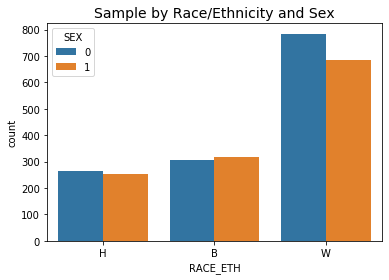

In [37]:
# Graphing demographics
ax = sns.countplot(x='RACE_ETH', hue='SEX', data=df_curfew)

#Formatting
ax.set_title('Sample by Race/Ethnicity and Sex', fontsize=14);

In [38]:
# Create 'Parenting' variable for graphing
def label_parenting(row):
   if row['U'] == 1 :
      return 'U'
   if row['P'] == 1 :
      return 'P'
   if row['N'] == 1 :
      return 'N'
   if row['A'] == 1:
      return 'A'
   else:
       return 0

df_curfew['PARENTING'] = df_curfew.apply(lambda row: label_parenting(row), axis=1)

# [post-regression copy]
df_curfew_arr['PARENTING'] = df_curfew_arr.apply(lambda row: label_parenting(row), axis=1)
df_curfew_incar['PARENTING'] = df_curfew_incar.apply(lambda row: label_parenting(row), axis=1)

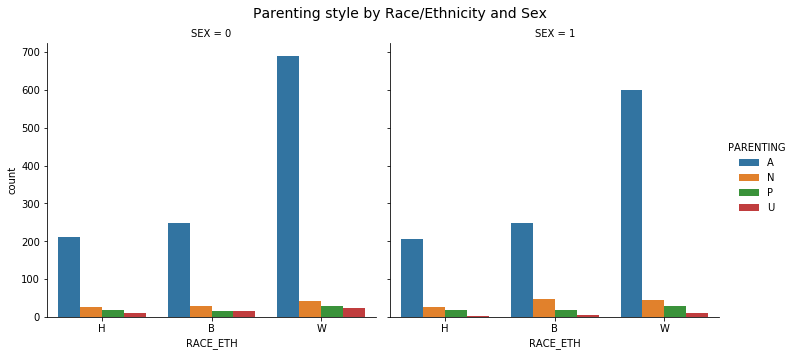

In [39]:
# Graphing key variables by demographics
g = sns.catplot(x='RACE_ETH', hue='PARENTING', col='SEX', data=df_curfew, kind='count', height=5, aspect=1)

#Formatting
plt.subplots_adjust(top=0.88)
g.fig.suptitle('Parenting style by Race/Ethnicity and Sex', fontsize=14);

In [40]:
# Uninvolved sums per race/sex group
print('HF', df_curfew[(df_curfew['U']==1) & (df_curfew['HF']==1)]['U'].sum())
print('BF', df_curfew[(df_curfew['U']==1) & (df_curfew['BF']==1)]['U'].sum())
print('WF', df_curfew[(df_curfew['U']==1) & (df_curfew['WF']==1)]['U'].sum())
print('HM', df_curfew[(df_curfew['U']==1) & (df_curfew['HM']==1)]['U'].sum())
print('BM', df_curfew[(df_curfew['U']==1) & (df_curfew['BM']==1)]['U'].sum())
print('WM', df_curfew[(df_curfew['U']==1) & (df_curfew['WM']==1)]['U'].sum())

HF 3
BF 5
WF 11
HM 10
BM 15
WM 23


**A note on Uninvolved parents: the smallest group**

The 67 respondents with Uninvolved parents make up ~2.6% of the sample size. While this is low, it's not problematic.


However, when we divide those respondents among their race/sex groups, the numbers get much smaller. Each group then becomes less than 1% of the sample size (about 26), which could be considered a "rare event".


This could be problematic for a model that uses SEX_RACE as a variable, especially for the smaller groups, if we have more explanatory variables than datapoints for a group. Further tests would be helpful for more information after performing the linear regression, but it's likely a linear model may not be the best fit for the data.


### Criminal variables

In [41]:
# Melt dataset for graphing
df_curfew_m2 = pd.melt(df_curfew[['ARREST_TOT', 'INCAR_TOT', 
                   'INCAR_TOT_MO', 'PARENTING']], 'PARENTING', 
                        var_name='ARR_INCAR')

df_curfew_m2.head()

PARENTING   ARR_INCAR  value
0         A  ARREST_TOT      0
1         N  ARREST_TOT      1
2         A  ARREST_TOT      0
3         P  ARREST_TOT      0
4         A  ARREST_TOT      0

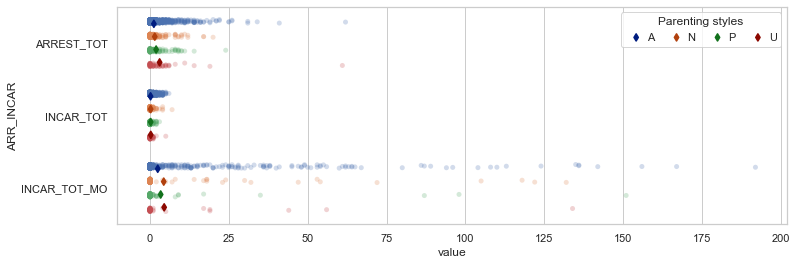

In [42]:
# Comparing three criminal variables across parenting styles
# (A) Authoritative, (N) Authoritarian, (P) Permissive, (U) Uninvolved

# Initialize plot
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(12, 4))


# Show each observation with a scatterplot
sns.stripplot(x='value', y='ARR_INCAR', hue='PARENTING',
              data=df_curfew_m2, dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x='value', y='ARR_INCAR', hue='PARENTING',
              data=df_curfew_m2, dodge=.532, join=False, palette='dark',
              markers="d", scale=.75, ci=None)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='Parenting styles',
          handletextpad=0, columnspacing=1,
          loc='upper right', ncol=4, frameon=True);


As we can see above for ARREST_TOT and INCAR_TOT_MO, Authoritative parents, characterized by rule enforcement and a positive relationship, have the lowest mean out of the four parenting styles.

While Uninvolved parenting (little guidance or attention) has the highest mean for ARREST_TOT and INCAR_TOT_MO, interestingly, the Authoritarian parenting (seeking obedience through punishment) mean is not far behind the Uninvolved mean for INCAR_TOT_MO.

Now let's combine our criminal justice variables with our sex/race variables to drill down for each group.

In [43]:
# Melt dataset for graphing
df_curfew_m1 = pd.melt(df_curfew[['ARREST_TOT', 'INCAR_TOT', 
                   'INCAR_TOT_MO', 'SEX_RACE']], 'SEX_RACE', 
                        var_name='ARR_INCAR')

df_curfew_m1.head()

SEX_RACE   ARR_INCAR  value
0       HF  ARREST_TOT      0
1       BM  ARREST_TOT      1
2       BF  ARREST_TOT      0
3       WF  ARREST_TOT      0
4       BF  ARREST_TOT      0

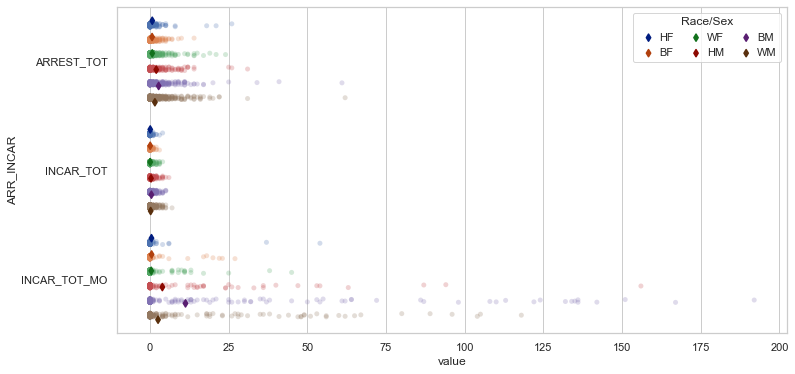

In [44]:
# Comparing three criminal variables across race/sex

# Initialize plot
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(12, 6))


# Show each observation with a scatterplot
sns.stripplot(x='value', y='ARR_INCAR', hue='SEX_RACE',
              data=df_curfew_m1, dodge=True, jitter=True,
              alpha=.25, zorder=1, hue_order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'))

# Show the conditional means
sns.pointplot(x='value', y='ARR_INCAR', hue='SEX_RACE',
              data=df_curfew_m1, dodge=.75, join=False, palette='dark',
              markers="d", scale=.75, ci=None, hue_order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'))

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:], title='Race/Sex',
          handletextpad=0, columnspacing=1,
          loc='upper right', ncol=3, frameon=True);


Unsurprisingly for those familiar, the women (blue, orange, green) have much lower means for ARREST_TOT and INCAR_TOT_MO. Likewise, we can see the amplification of black males (purple) in months incarcerated compared to white males (brown) and Hispanic males (red) in INCAR_TOT_MO.

Let's take a closer look:

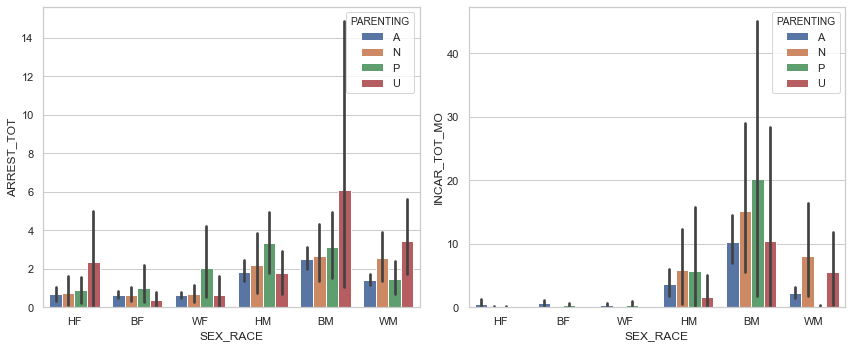

In [45]:
# Compare total arrests and months incarcerated across race/sex groups and parenting types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.catplot(x='SEX_RACE', y='ARREST_TOT', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax1)

sns.catplot(x='SEX_RACE', y='INCAR_TOT_MO', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax2)

# close empty catplots
plt.close(2)
plt.close(3)
plt.tight_layout();

It's notable that both Permissive and Uninvolved parenting have the highest means for most race/sex groups.

The change in black males from arrests to months incarcerated is very interesting. While black males with Uninvolved parents make up twice the arrests of black males with Permissive parents (means of about 6 and 3), that relationship switches for months incarcerated (means of about 20 for Permissive and 10 for Uninvolved).

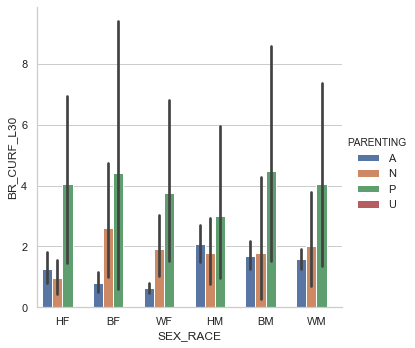

In [46]:
sns.catplot(x='SEX_RACE', y='BR_CURF_L30', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'));

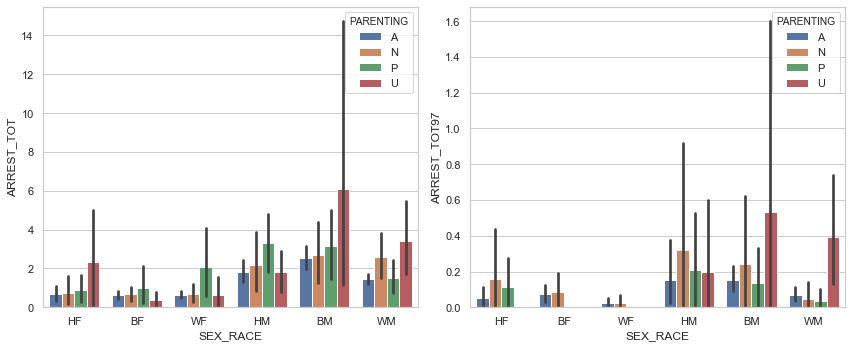

In [47]:
# Compare total arrests and arrests in youth across race/sex groups and parenting types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.catplot(x='SEX_RACE', y='ARREST_TOT', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax1)

sns.catplot(x='SEX_RACE', y='ARREST_TOT97', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax2)

# close empty catplots
plt.close(2)
plt.close(3)
plt.tight_layout();

In [48]:
# Compare total arrests and arrests in youth across race/sex groups and parenting types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.catplot(x='SEX_RACE', y='ARREST_TOT97', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax1)

sns.catplot(x='SEX_RACE', y='R_ARRESTED_EV', hue='PARENTING',
                data=df_curfew, kind='bar', order=('HF', 'BF', 'WF', 'HM', 'BM', 'WM'), ax=ax2)

# close empty catplots
plt.close(2)
plt.close(3)
plt.tight_layout();

### Income variable

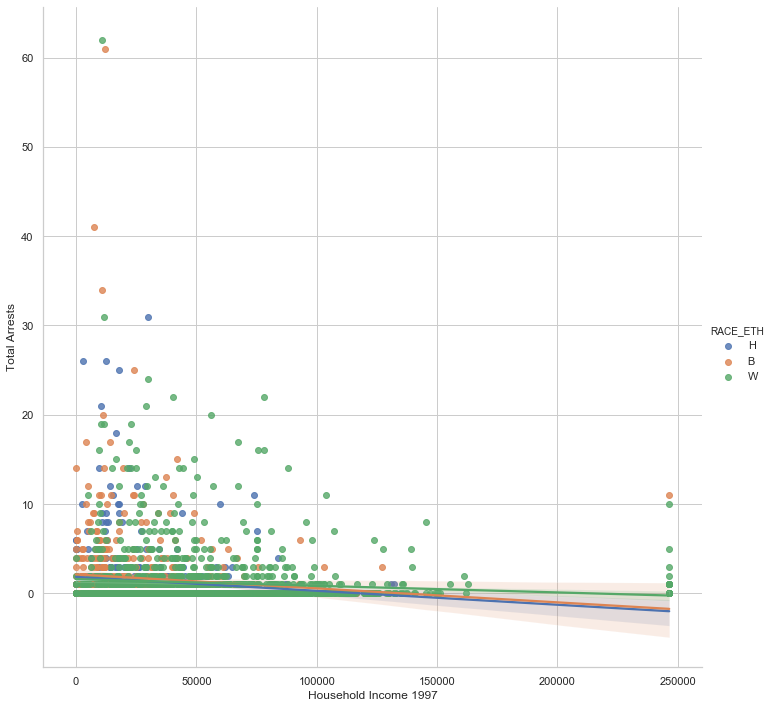

In [49]:
# Race and income
g = sns.lmplot(x='HH_INCOME97', y='ARREST_TOT', hue='RACE_ETH', 
               truncate=True, height=10, data=df_curfew)
g.set_axis_labels('Household Income 1997', 'Total Arrests');

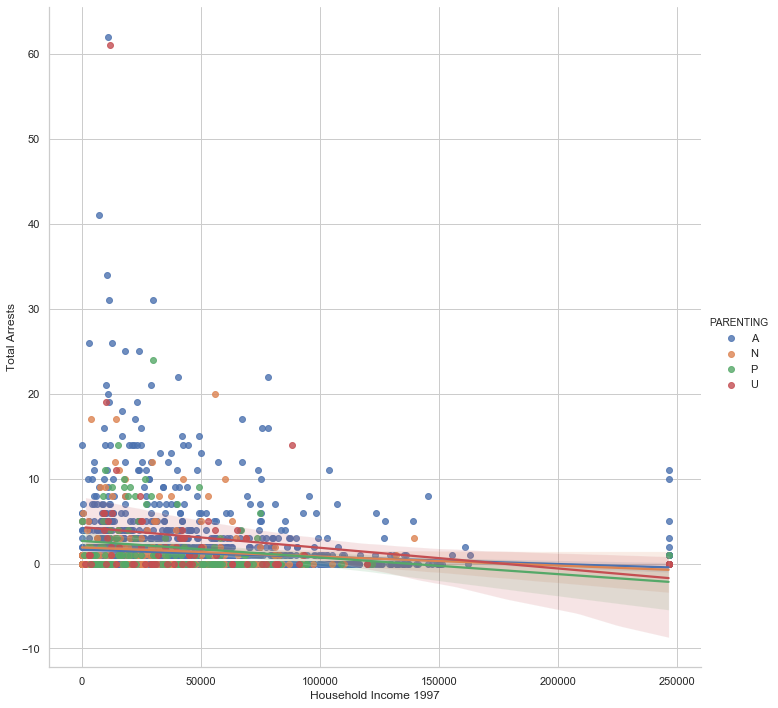

In [50]:
#Parenting style and income
g = sns.lmplot(x='HH_INCOME97', y='ARREST_TOT', hue='PARENTING', 
               truncate=True, height=10, data=df_curfew)

g.set_axis_labels('Household Income 1997', 'Total Arrests');

In [51]:
df_curfew['HH_INCOME97_LOG'] = np.log(df_curfew.loc[df_curfew.HH_INCOME97 > 0, 'HH_INCOME97'])

df_curfew['HH_INCOME97_LOG'].fillna(0, inplace=True)

df_curfew['HH_INCOME97_LOG']

2       11.050890
18       0.000000
27       9.472705
33       9.190138
47       8.612503
          ...    
8962    10.607179
8963    10.607179
8973    10.609057
8975     8.716044
8978    11.156251
Name: HH_INCOME97_LOG, Length: 2611, dtype: float64

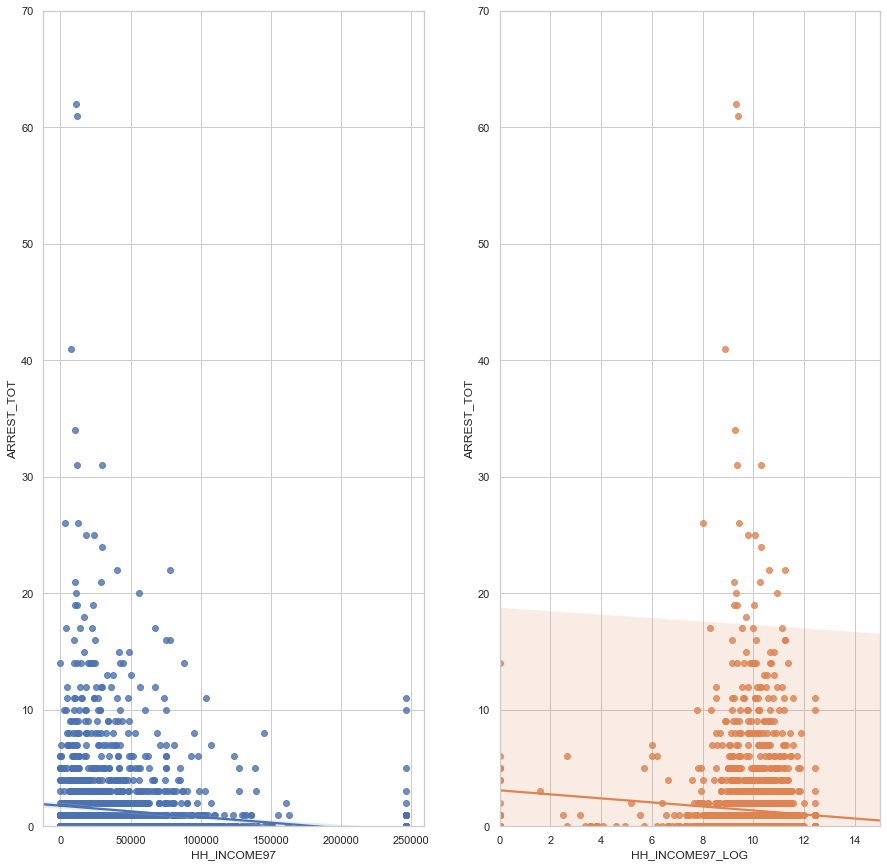

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))
sns.regplot(x='HH_INCOME97', y='ARREST_TOT', data=df_curfew, ax=ax1)
ax1.set_ylim([0, 70])

sns.regplot(x='HH_INCOME97_LOG', y='ARREST_TOT', data=df_curfew, ax=ax2)
ax2.set_ylim([0, 70])
ax2.set_xlim([0, 15]);

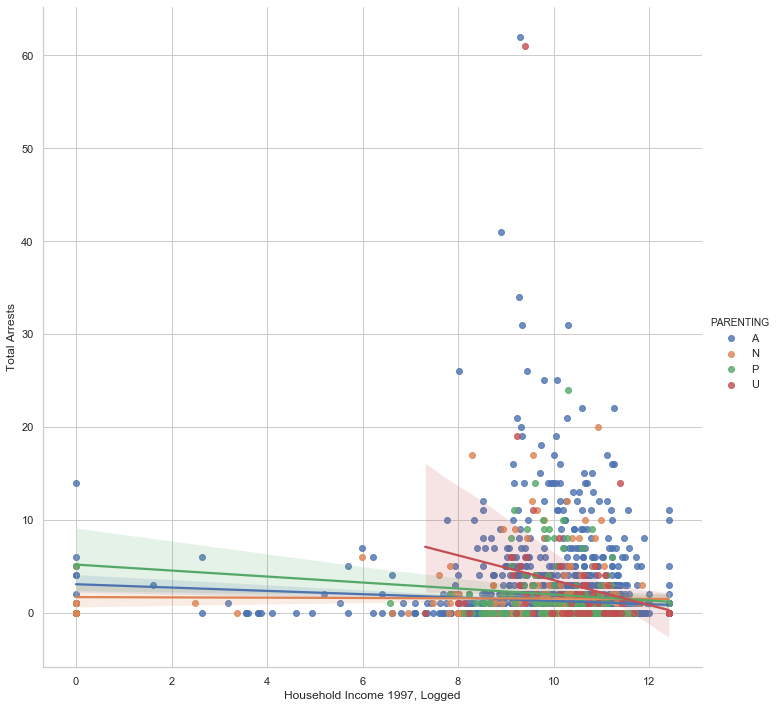

In [53]:
g = sns.lmplot(x='HH_INCOME97_LOG', y='ARREST_TOT', hue='PARENTING', 
               truncate=True, height=10, data=df_curfew)

g.set_axis_labels('Household Income 1997, Logged', 'Total Arrests');

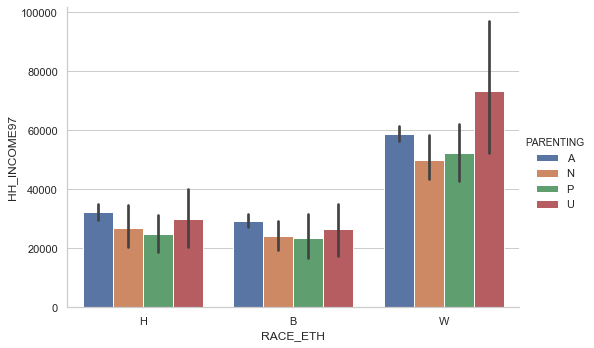

In [54]:
sns.catplot(x='RACE_ETH', y='HH_INCOME97', hue='PARENTING',
                data=df_curfew, kind='bar', height=5, aspect=1.5);

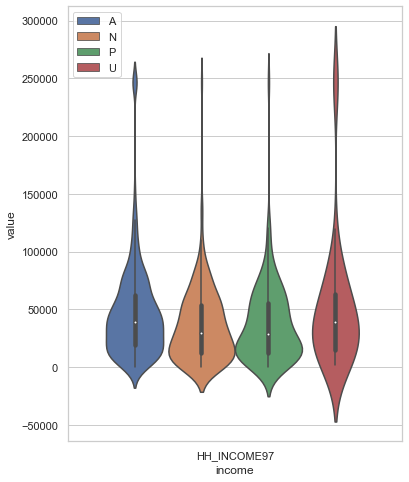

In [55]:
# melt dataset for graphing
df_curfew_m3 = pd.melt(df_curfew[['HH_INCOME97', 
                 'PARENTING']], 'PARENTING', 
                        var_name='income')

ax = plt.subplots(figsize=(6, 8))

ax = sns.violinplot(x='income', y='value', hue='PARENTING',
                    data=df_curfew_m3)

ax.legend(loc='upper left');

It's difficult to tell if income or logged income is better for the model. We can see from the violinplot above that there's more variation in income for Uninvolved parents.

From the catplot above the violinplot, we can see that Uninvolved parents make more on average than Authoritarian and Permissive parents for each racial/ethnic group. For whites in particular, Uninvolved parents make the highest average income compared to the other three parenting style groups.

The linear plots above show how the income data is far from homogenous, which violates a basic OLS assumption. We'll see if it's worth keeping in the model, although it's clear it will be imperfect (not BLUE) if we include it.

### Gang-related variables

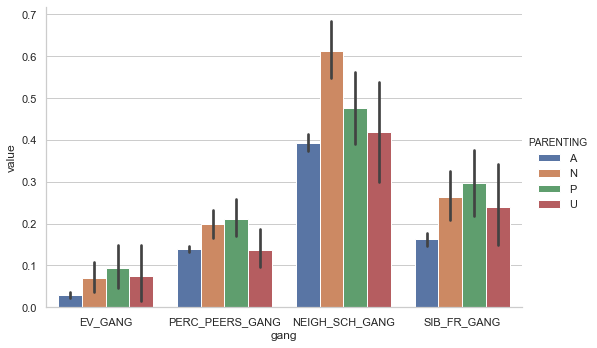

In [56]:
# Melt dataset for graphing
df_curfew_m4 = pd.melt(df_curfew[['EV_GANG', 'PERC_PEERS_GANG', 
                'NEIGH_SCH_GANG', 'SIB_FR_GANG',
                'PARENTING']], 'PARENTING', 
                        var_name='gang')

# Explore gang related variables
sns.catplot(x='gang', y='value', hue='PARENTING',
                data=df_curfew_m4, kind='bar', height=5, aspect=1.5);



Interestingly, respondents with Authoritarian and Permissive parents have higher averages of gang activity in their environment than Uninvolved parents for each gang-related variable.

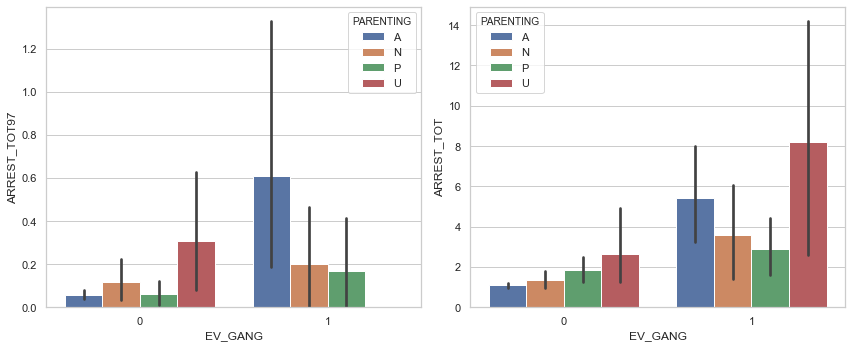

In [57]:
# plot EV_GANG and ARREST_TOT97
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.catplot(x='EV_GANG', y='ARREST_TOT97', hue='PARENTING',
                data=df_curfew, kind='bar', ax=ax1)

sns.catplot(x='EV_GANG', y='ARREST_TOT', hue='PARENTING',
                data=df_curfew, kind='bar', ax=ax2)

# close empty catplots
plt.close(2)
plt.close(3)
plt.tight_layout();

Interestingly, in 1997 (when the respondents were 13 or younger), those in a gang and getting into trouble via arrests were overwhelmingly parented by Authoritative parents (characterized by rule enforcement and a positive relationship). Noticebly, no kids parented by Uninvolved parents who were in a gang were arrested by the time of the survey in 1997.

Yet, into adulthood, those with the most arrests who were in a gang as a youth were parented by Uninvolved parents.

Somehow those with Uninvolved parents who were in a gang evaded arrests as kids but not as adults.

Those with the other three parenting styles who were in a gang as a youth have a similar ratio of arrests in 1997 as total arrests later in adulthood.

## Linear regression

In [58]:
df_curfew = sm.add_constant(df_curfew) #adding constant to dataframe

df_curfew.columns

C:\Users\Hillary\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Index(['const', 'ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P', 'B', 'H', 'W',
       'SEX_RACE', 'BF', 'BM', 'HF', 'HM', 'WF', 'WM', 'PARENTING',
       'HH_INCOME97_LOG'],
      dtype='object')

### Regression #1: *un*interacted race and sex groups

In [59]:
# Linear regression #1a - first run through
x = df_curfew[['const', 'EV_GANG', 'SIB_FR_GANG', 'PERC_PEERS_GANG', 'NEIGH_SCH_GANG', 'ARREST_TOT97', 'BR_CURF_L30', 'R_ARRESTED_EV',
               'HH_INCOME97', 'HH_INCOME97_LOG', 'B', 'H', 'SEX', 'U', 'P', 'N']] # White (W) and Authoritative (A) are reference groups for race and parenting style

y = df_curfew[['ARREST_TOT']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

# Interpretation of coefficients: compared to white male with Authoritative parenting

                            OLS Regression Results                            
Dep. Variable:             ARREST_TOT   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     38.89
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          8.40e-103
Time:                        18:28:56   Log-Likelihood:                -6774.2
No. Observations:                2611   AIC:                         1.358e+04
Df Residuals:                    2595   BIC:                         1.367e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1082      0.491     

#### Multicollinearity via VIFs & dropping variables
* There's surprisingly little multicollinearity among the gang-related variables, the income and logged income, and all other variables. For context, a rule of thumb for interpreting VIF: 
    * x = 1  -> not correlated
    * 1 < x <  5  -> moderately correlated
    * x > 5  -> highly correlated


* After tinkering with the model, it's apparent that the high conditon number and warnings are from the income variable HH_INCOME97. While this may be a cause for concern, our VIF test is more specific, and lets us know the issue is not multicollinear. Yet, we know from exploring the data that the heterogenity of income is an issue. While the income variable is statistically significant, it's explantory value in the model is exceedingly small (-5.638e-06).


* I'm going to drop both income variables. I initially considered only dropping the logged income for its lack of explantory power. The reason for dropping HH_INCOME97 too? We sacrificed a few hundred observations (including about 30 belonging to the tiny Uninvolved parents group) in order to use the variable in the regression. I think it's worth losing a tiny bit of explanatory power even if it's statistically signficant if it means getting hundreds more observations (and 50% more of our "rare event" observations of the Uninvoled parents).


* Also going to drop the two gang-related variables PERC_PEERS_GANG and NEIGH_SCH_GANG for their lack of explanatory value.


#### Interpretation
Keep in mind our reference group is white males with Authoritative parenting.

##### Parenting style variables
Most of our explanatory variables are highly significant, most notably the 'U' for Uninvolved parents. Those with Uninvolved parents are statistically likely to have ~1.2 more arrests than those with Authoritative (A) parents. Our other parenting variables are not signficant.

*For Uninvolved parenting, we can reject the null at the 1% level.*

##### Gang-related variables
The two gang-related variables closer to the survey respondent are highly significant (EV_GANG, SIB_FR_GANG) while the other two (PERC_PEERS_GANG, NEIGH_SCH_GANG) are not. EV_GANG has the largest coefficient at ~2.3 more arrests in adulthood if the youth had ever been in a gang by the time of the survey.

##### Demographic variables
I was surprised to see Black be statistically insigificant, likely because males and females are mixed together. SEX has a p-value of 0.000 with a coefficient of ~ -1, which is expected since women have much fewer arrests than men across all races/ethnicities.

In [60]:
# I created a copy of df_curfew without the dropped observations during cleaning caused by HH_INCOME97 and a few other variables
df_curfew_arr = sm.add_constant(df_curfew_arr) #adding constant to dataframe

df_curfew_arr.columns

Index(['const', 'ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P', 'B', 'H', 'O', 'W',
       'SEX_RACE', 'BF', 'BM', 'HF', 'HM', 'OF', 'OM', 'WF', 'WM',
       'PARENTING'],
      dtype='object')

In [61]:
# Linear regression #1b - like 1a minus variables with low explanatory power/ causing a bit of multicollinearity
x = df_curfew_arr[['const', 'EV_GANG', 'SIB_FR_GANG', 'ARREST_TOT97', 'BR_CURF_L30', 'R_ARRESTED_EV',
                 'B', 'H', 'SEX', 'U', 'P', 'N']] # White (W) and Authoritative (A) are reference groups for race and parenting style

y = df_curfew_arr[['ARREST_TOT']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

# Interpretation of coefficients: compared to white male with Authoritative parenting

                            OLS Regression Results                            
Dep. Variable:             ARREST_TOT   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     64.08
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          1.07e-130
Time:                        18:28:56   Log-Likelihood:                -9001.8
No. Observations:                3489   AIC:                         1.803e+04
Df Residuals:                    3477   BIC:                         1.810e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2409      0.096     12.993

#### VIFs change
Our VIFs are looking much better, even our constant by a dramatic amount, from about 60 to 3!

#### Using df_curfew_arr, includes previously dropped observations due to including HH_INCOME97 and others
Very interesting. With more observations from dropping a few variables (namely HH_INCOME97), Uninvolved parents (U) is less significant with a much lower coefficient. This is good--it shows just how sensitive this small group is. Now that it is about 50% larger than before, it should give us more accurate information.

*For Uninvolved parenting, we can reject the null at the 10% level.*

Let's see if interacting race and sex groups helps us see how parenting styles affect these groups better.

### Regression #2: *interacted* race and sex groups

In [62]:
# Linear regression #2a - using interacted race and sex groups
x = df_curfew_arr[['const', 'EV_GANG', 'SIB_FR_GANG', 'ARREST_TOT97', 'BR_CURF_L30', 'R_ARRESTED_EV',
               'BF', 'BM', 'HF', 'HM', 'WF', 'U', 'P', 'N']] # White male and Authoritative parenting are reference groups
y = df_curfew_arr[['ARREST_TOT']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

# Interpretation of coefficients: compared to white male with Authoritative parenting

                            OLS Regression Results                            
Dep. Variable:             ARREST_TOT   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     55.43
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          9.12e-132
Time:                        18:28:56   Log-Likelihood:                -8995.0
No. Observations:                3489   AIC:                         1.802e+04
Df Residuals:                    3475   BIC:                         1.810e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0810      0.106     10.202

#### Interpretation

##### Parenting style variables
*Uninvolved (U) and Permissive (P) parenting are both significant enough to reject the null at the 10% level.*

Uninvolved parents corrlate with ~0.55 more arrests and Permissive parents correlate with ~0.42 more arrests than youth with Authoritative (A) parents (our reference group).

##### Demographics
Now that our black variables are split by sex (BM, BF), they are both significant at the 0.000 level. Since just black (B) by itself was highly insignificant, this goes to show just how important race/sex interactions are when using criminal justice related variables. All race/sex groups are sig. at the 0.000 level except Hispanic men (HM).

##### Gang-related and other criminal variables
These are all highly significant with p-values of 0.000. Having ever been in a gang (EV_GANG) has the largest impact, ~2.36 more arrests. Being arrested in youth (R_ARRESTED_EV and ARREST_TOT97) also have large impacts, ~1.30 and ~1.36 respectively.

### Regression #3: interacted race, sex, *and parenting style* groups

In [63]:
df_curfew_arr['RACE_SEX_PAR'] = df_curfew_arr['SEX_RACE'] + ' '+ df_curfew_arr['PARENTING']

race_sex_curfew_dummies = pd.get_dummies(df_curfew_arr.RACE_SEX_PAR)
df_curfew_arr = pd.concat([df_curfew_arr, race_sex_curfew_dummies], axis=1)

df_curfew_arr.columns

Index(['const', 'ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P', 'B', 'H', 'O', 'W',
       'SEX_RACE', 'BF', 'BM', 'HF', 'HM', 'OF', 'OM', 'WF', 'WM', 'PARENTING',
       'RACE_SEX_PAR', 'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
       'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
       'OF A', 'OF N', 'OF P', 'OM A', 'OM P', 'OM U', 'WF A', 'WF N', 'WF P',
       'WF U', 'WM A', 'WM N', 'WM P', 'WM U'],
      dtype='object')

In [64]:
# Linear regression #3a - using sex, race, and parenting style interacted terms
x = df_curfew_arr[['const', 'EV_GANG', 'SIB_FR_GANG', 'ARREST_TOT97', 'BR_CURF_L30', 'R_ARRESTED_EV',
               'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
               'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
               'WF A', 'WF N', 'WF P', 'WF U', 'WM N', 'WM P', 'WM U']]

y = df_curfew_arr[['ARREST_TOT']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

                            OLS Regression Results                            
Dep. Variable:             ARREST_TOT   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     26.33
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          2.45e-123
Time:                        18:28:56   Log-Likelihood:                -8986.8
No. Observations:                3489   AIC:                         1.803e+04
Df Residuals:                    3460   BIC:                         1.821e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0481      0.111      9.448

#### Intrepretation
Our adjusted R-squared is the same as the previous regression. Regardless, we can interpret parenting styles on our different sex/race groups in a much more targetted manner now.

I'll be using the variable names for brevity:
Authoritative (A), Authoritarian (N), Permissive (P), and Uninvolved (U)

* Black females: sig. at the 1% level for A and N
* Black males: sig at the 1% level for A, N, and U; P is sig at the 7% level.
* Hispanic females: sig for A, N, and P at 0%, 4%, and 7% sig levels
* Hispanic males: sig at the 7% level for P
* White females: only sig for A at p = 0.000
* White males: interestingly, none for white males are significant.

All significant coefficients are negative for women and positive for men, as compared to our reference group, white men with A parents.

For black males, it's clear that Uninvolved parents correlate with the most arrests: ~2.6 more than white men with Authoritative parents. Authoritarian and Permissive parents give similar coeffeicents: ~1.6 and ~1.3. Authoritative parents correlate with the least arrests for black men: ~0.6 more than white men with the same parenting style.

For Hispanic males, only Permissive parenting is significant, with ~1.2 more arrests than white males with Authoritative parents.

What would happen if we go even deeper?

In [65]:
# Linear regression #3b - using sex, race, and parenting style interacted terms AND sex/race interacted terms
x = df_curfew_arr[['const', 'EV_GANG', 'SIB_FR_GANG', 'ARREST_TOT97', 'BR_CURF_L30', 'R_ARRESTED_EV', 'BF', 'BM', 'HF', 'HM', 'WF',
               'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
               'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
               'WF A', 'WF N', 'WF P', 'WF U', 'WM N', 'WM P', 'WM U']]

y = df_curfew_arr[['ARREST_TOT']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

                            OLS Regression Results                            
Dep. Variable:             ARREST_TOT   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     26.33
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          2.45e-123
Time:                        18:28:56   Log-Likelihood:                -8986.8
No. Observations:                3489   AIC:                         1.803e+04
Df Residuals:                    3460   BIC:                         1.821e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0481      0.111      9.448

C:\Users\Hillary\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF Factor       features
0     4.210861          const
1     1.091544        EV_GANG
2     1.111696    SIB_FR_GANG
3     1.757104   ARREST_TOT97
4     1.071123    BR_CURF_L30
5     1.776619  R_ARRESTED_EV
6          inf             BF
7          inf             BM
8          inf             HF
9          inf             HM
10         inf             WF
11         inf           BF A
12         inf           BF N
13         inf           BF P
14         inf           BF U
15         inf           BM A
16         inf           BM N
17         inf           BM P
18         inf           BM U
19         inf           HF A
20         inf           HF N
21         inf           HF P
22         inf           HF U
23         inf           HM A
24         inf           HM N
25         inf           HM P
26         inf           HM U
27         inf           WF A
28         inf           WF N
29         inf           WF P
30         inf           WF U
31    1.047703           WM N
32    1.03

Below: playing around with INCAR_TOT_MO as dependent variable.

In [66]:
df_curfew_incar = sm.add_constant(df_curfew_incar) #adding constant to dataframe

df_curfew_incar.columns

Index(['const', 'ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P', 'B', 'H', 'O', 'W',
       'SEX_RACE', 'BF', 'BM', 'HF', 'HM', 'OF', 'OM', 'WF', 'WM',
       'PARENTING'],
      dtype='object')

In [67]:
df_curfew_incar['RACE_SEX_PAR'] = df_curfew_incar['SEX_RACE'] + ' '+ df_curfew_incar['PARENTING']

race_sex_curfew_dummies = pd.get_dummies(df_curfew_incar.RACE_SEX_PAR)
df_curfew_incar = pd.concat([df_curfew_incar, race_sex_curfew_dummies], axis=1)

df_curfew_incar.columns

Index(['const', 'ARREST_TOT', 'INCAR_TOT', 'INCAR_TOT_MO', 'PERC_PEERS_GANG',
       'WHO_SETS_CURF', 'BR_CURF_L30', 'CURF_ENFORCM', 'NEIGH_SCH_GANG',
       'SIB_FR_GANG', 'EV_GANG', 'R_ARRESTED_EV', 'ARREST_TOT97', 'SEX',
       'HH_INCOME97', 'RACE_ETH', 'U', 'A', 'N', 'P', 'B', 'H', 'O', 'W',
       'SEX_RACE', 'BF', 'BM', 'HF', 'HM', 'OF', 'OM', 'WF', 'WM', 'PARENTING',
       'RACE_SEX_PAR', 'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
       'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
       'OF A', 'OF N', 'OF P', 'OM A', 'OM P', 'OM U', 'WF A', 'WF N', 'WF P',
       'WF U', 'WM A', 'WM N', 'WM P', 'WM U'],
      dtype='object')

In [68]:
# Linear regression #1b - like 1a minus variables with low explanatory power/ causing a bit of multicollinearity
x = df_curfew_incar[['const', 'EV_GANG', 'PERC_PEERS_GANG', 'ARREST_TOT97', 'R_ARRESTED_EV',
                'B', 'H', 'SEX', 'U', 'P', 'N']] # White (W) and Authoritative (A) are reference groups for race and parenting style

y = df_curfew_incar[['INCAR_TOT_MO']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

# Interpretation of coefficients: compared to white male with Authoritative parenting

                            OLS Regression Results                            
Dep. Variable:           INCAR_TOT_MO   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     25.48
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           3.46e-47
Time:                        18:28:57   Log-Likelihood:                -14039.
No. Observations:                3481   AIC:                         2.810e+04
Df Residuals:                    3470   BIC:                         2.817e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.6310      0.417     

In [69]:
# Linear regression #2a - using interacted race and sex groups
x = df_curfew_incar[['const', 'EV_GANG', 'PERC_PEERS_GANG', 'ARREST_TOT97', 'R_ARRESTED_EV',
               'BF', 'BM', 'HF', 'HM', 'WF', 'U', 'P', 'N']] # White male and Authoritative parenting are reference groups
y = df_curfew_incar[['INCAR_TOT_MO']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

# Interpretation of coefficients: compared to white male with Authoritative parenting

                            OLS Regression Results                            
Dep. Variable:           INCAR_TOT_MO   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     25.97
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           7.99e-57
Time:                        18:28:57   Log-Likelihood:                -14012.
No. Observations:                3481   AIC:                         2.805e+04
Df Residuals:                    3468   BIC:                         2.813e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5132      0.458     

In [70]:
# Linear regression #3a - using sex, race, and parenting style interacted terms
x = df_curfew_incar[['const', 'EV_GANG', 'PERC_PEERS_GANG', 'ARREST_TOT97', 'R_ARRESTED_EV',
               'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
               'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
               'WF A', 'WF N', 'WF P', 'WF U', 'WM N', 'WM P', 'WM U']]

y = df_curfew_incar[['INCAR_TOT_MO']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

                            OLS Regression Results                            
Dep. Variable:           INCAR_TOT_MO   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     12.18
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           6.49e-51
Time:                        18:28:57   Log-Likelihood:                -14004.
No. Observations:                3481   AIC:                         2.806e+04
Df Residuals:                    3453   BIC:                         2.824e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4396      0.479     

In [71]:
# Linear regression #3a - using sex, race, and parenting style interacted terms
x = df_curfew_incar[['const', 'EV_GANG', 'PERC_PEERS_GANG', 'ARREST_TOT97', 'R_ARRESTED_EV', 'BM', 'BF', 'HF', 'HM', 'WF',
               'BF A', 'BF N', 'BF P', 'BF U', 'BM A', 'BM N', 'BM P',
               'BM U', 'HF A', 'HF N', 'HF P', 'HF U', 'HM A', 'HM N', 'HM P', 'HM U',
               'WF A', 'WF N', 'WF P', 'WF U', 'WM N', 'WM P', 'WM U']]

y = df_curfew_incar[['INCAR_TOT_MO']]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

X = x

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

                            OLS Regression Results                            
Dep. Variable:           INCAR_TOT_MO   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     12.18
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           6.49e-51
Time:                        18:28:57   Log-Likelihood:                -14004.
No. Observations:                3481   AIC:                         2.806e+04
Df Residuals:                    3453   BIC:                         2.824e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4396      0.479     